# Bounding Box regression on Image Localization Dataset

- X --> Input Image
- Y = [bbox_coords, one-hot_repr_of_class] --> [xmin, y_min, x_max, y_max, one-hot]

- Where
    - x_min, y_min are co-ordinates of top left corner
    - x_max, y_max are co-ordinates of bottom-right corner of the bounding box

## Converting xml files to single csv file

In [1]:
import tensorflow as tf

# physical_devices = tf.config.experimental.list_physical_devices('GPU')
# tf.config.experimental.set_memory_growth(physical_devices[0], True) 

In [2]:
def get_bbox_coords(xml_dict):
    obj = xml_dict['annotation']['object']
    bbox = obj['bndbox']
    size = int(xml_dict['annotation']['size']['height'])  # or widht. both are same
    assert size == 227
    keys = ['xmin', 'ymin', 'xmax', 'ymax']
    bbox_coords = [float(bbox[key])/size for key in keys]

    return bbox_coords

In [3]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import glob, xmltodict

In [4]:
if not os.path.isfile('bbox_label.csv'):
    xml_csv_list = list()
    for xml in glob.glob('training_images/*.xml'):
        with open(xml, 'rb') as fp:
            xml_dict = xmltodict.parse(fp)

        file_name = xml_dict['annotation']['filename']
        bbox_coords = get_bbox_coords(xml_dict)
        label=xml_dict['annotation']['object']['name']

        xml_csv_list.append([file_name] + bbox_coords +[label])

    column_names = ['image', 'xmin','ymin', 'xmax', 'ymax', 'label']
    df = pd.DataFrame(data=xml_csv_list, columns=column_names)
    df.to_csv('bbox_label.csv', index=False)
else:
    
    df = pd.read_csv('bbox_label.csv')

## Loading Image Localization Dataset 

In [5]:
# confirming the sizes of the dataset

In [6]:
images = glob.glob('training_images/*.jpg')

In [7]:
import cv2

In [8]:
for path in images:
    img = cv2.imread(path)
    assert img.shape==(227, 227, 3)

In [9]:
len(images)

186

In [10]:
import numpy as np

In [11]:
CLASS_NAMES = np.array(['cucumber', 'eggplant', 'mushroom'])
CLASS_NAMES

array(['cucumber', 'eggplant', 'mushroom'], dtype='<U8')

In [12]:
# we can get the one-hot encoded of the class name using this
'cucumber' == CLASS_NAMES

array([ True, False, False])

### Creating data pipeline using tf.data

In [13]:
train_ds = tf.data.Dataset.from_tensor_slices(
    tensors=(df['image'].values,
             df['label'].values,
             df.drop(['image', 'label'], axis=1).values)
)

In [396]:
def parse_data(image_path, label, bbox):

    def get_input_image(file_path):
        # read the jpg image to numpy array
        image = tf.io.read_file(file_path)
        image = tf.image.decode_jpeg(image)
        # normalize the image
        image = image/255
        # just to make sure
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        return image
    
    # get the input image (Normalized)
    image = get_input_image('training_images/'+image_path)
    
    # output_vector: [bbox_coords, one-hot_encoded label]
    bbox_coords = tf.cast(bbox, tf.float32)
    one_hot_label = tf.cast(label==CLASS_NAMES, tf.float32)
    bbox_label = tf.concat(values=(bbox_coords, one_hot_label), axis=0)
    
    return image, bbox_label

In [15]:
for image_path, label, bbox in train_ds.take(1):
    image, bbox_label = parse_data(image_path, label, bbox)

In [16]:
image.shape, bbox_label.shape

(TensorShape([227, 227, 3]), TensorShape([7]))

In [17]:
del image, bbox_label

#### Prepare the training dataset

In [18]:
BATCH_SIZE=32
cache='train.tfcache'
# cache=True

In [397]:
def prepare_dataset(ds, batch_size=32, train=False, cache=False):
    
    ds = ds.map(map_func=parse_data)
    ds = ds.batch(batch_size=batch_size)
    
    # apply cache to the dataset for faster pipelines
    if cache:
        if isinstance(cache, str):  # cache in files
            ds = ds.cache(cache)
        else:  # if all the data can fit in the memory
            ds = ds.cache()
    
    # shuffle called after `cache` to avoid same batch every 
    # iteration from cache.
    if train:
        ds.shuffle(df.shape[0])

    # prefetch the data
    ds = ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return ds

In [398]:
train_ds = prepare_dataset(train_ds, batch_size=BATCH_SIZE, train=True, cache=cache)

TypeError: in converted code:


    TypeError: tf__parse_data() missing 1 required positional argument: 'bbox'


In [21]:
for images, bbox_labels in train_ds.take(1):
    pass

In [22]:
images.shape, bbox_labels.shape

(TensorShape([32, 227, 227, 3]), TensorShape([32, 7]))

## Creating model

In [399]:
INPUT_SIZE = (227, 227, 3)
INPUT_SIZE

(227, 227, 3)

In [400]:
_LEAKY_RELU = 0.2
_LEAKY_RELU

0.2

### Conv and Dense blocks( building blocks of the model )

In [25]:
class ConvBlock(tf.keras.Model):
    def __init__(self, filters, name, **kwargs):
        super(ConvBlock, self).__init__(name=name)
        # define layers with a name scope
        with tf.name_scope(name):
            self.conv_block = Sequential(layers=[
                layers.Conv2D(filters=filters, kernel_size=3, strides=1,padding='valid'),
                layers.LeakyReLU(alpha=_LEAKY_RELU),
                
                layers.Conv2D(filters=filters, kernel_size=3, strides=1, padding='valid'),
                layers.LeakyReLU(alpha=_LEAKY_RELU),
                
                layers.MaxPool2D(pool_size=2)
            ])
            
    def call(self, x):
        return self.conv_block(x)


class DenseBlock(tf.keras.Model):
    def __init__(self, units, name, **kwargs):
        super(DenseBlock, self).__init__(name=name, **kwargs)
        with tf.name_scope(name):
            self.dense_block = Sequential(layers=[
                layers.Dense(units=units),
                layers.LeakyReLU(alpha=_LEAKY_RELU)
            ])

    def call(self, x):
        return self.dense_block(x)

### Custom Loss function

In [326]:
@tf.function
def MSE_CCE_IOU(gt, pred, name='MSE_IOU Loss'):
    """ L = mse + (1-iou)"""
    # y[:,:4] --> bbox coordinates, y[:, 4:] --> one-hot-encoded class label
    def iou_score( target_boxes , pred_boxes ):
        xA = tf.maximum( target_boxes[:,0], pred_boxes[:,0] )
        yA = tf.maximum( target_boxes[:,1], pred_boxes[:,1] )
        xB = tf.minimum( target_boxes[:,2], pred_boxes[:,2] )
        yB = tf.minimum( target_boxes[:,3], pred_boxes[:,3] )
        interArea = tf.maximum(tf.constant(0, dtype=tf.float32), xB - xA) *\
                    tf.maximum(tf.constant(0, dtype=tf.float32), yB - yA)
        boxAArea = (target_boxes[ ... , 2] - target_boxes[ ... , 0] + 1) *\
                   (target_boxes[ ... , 3] - target_boxes[ ... , 1] + 1)
        boxBArea = (pred_boxes[ ... , 2] - pred_boxes[ ... , 0]+1) *\
                    (pred_boxes[ ... , 3] - pred_boxes[ ... , 1]+1)
        iou = interArea / ( boxAArea + boxBArea - interArea )
        return iou
    # calculate the mean squared error for one-hot encoded label
    mse = tf.losses.mean_squared_error(y_true=gt[:, :4], y_pred=pred[:, :4])    
    cce = tf.losses.categorical_crossentropy(y_true=gt[:,4:], y_pred=pred[:, 4:],
                                             from_logits=True)
    # calculate iou score for predicted and true bbox coordinates
    iou = iou_score(gt[:, :4], pred[: ,:4])
    
    return tf.reduce_mean(mse + cce + (1 - iou))

In [327]:
%%time
MSE_CCE_IOU(bbox_labels, bbox_labels)  # expected to be zero

Wall time: 616 ms


<tf.Tensor: id=350755, shape=(), dtype=float32, numpy=1.4715731>

### Model definition

In [328]:
from tensorflow.keras import layers, Sequential

In [329]:
class BBRegressor(tf.keras.Model):
    
    def __init__(self, name='Bbox regressor', **kwargs):
        super(BBRegressor, self).__init__(name=name, **kwargs)
        
        # convolutional block ( feature map )
        with tf.name_scope('ConvBlocks'):
            self.convblocks = Sequential(layers=[
                ConvBlock(filters=16, name='cblock1'),
                ConvBlock(filters=32, name='cblock2'),
                ConvBlock(filters=64, name='cblock3'),
                ConvBlock(filters=128, name='cblock4'),
                ConvBlock(filters=256, name='cblock5'),               
            ], name='ConvBlock')
      
        
        # dense layers
        with tf.name_scope('DenseBlocks'):
            self.denseblocks = Sequential(layers=[
                DenseBlock(units=1024, name='dblock1'),
                DenseBlock(units=512, name='dblock2'),
                DenseBlock(units=256, name='dblock3'),
                DenseBlock(units=128, name='dblock4'),
                DenseBlock(units=64, name='dblock5')
            ], name='DenseBlocks')
        
        # create a linear layer (last layer) without activation
        # 7 --> 4(bbox coords) + 3(#classes)
        with tf.name_scope('OutputLayer'):
            self.out = layers.Dense(units=7, activation=None) 

    @tf.function
    def call(self, x):
        x = self.convblocks(x)
        
        # flatten the output
        x = tf.reshape(x, shape=(x.shape[0], -1))
        x = self.denseblocks(x)
        
        return self.out(x)

In [330]:
model = BBRegressor()

model.build(input_shape=(1,)+INPUT_SIZE)
model.summary()

Model: "Bbox regressor"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
ConvBlock (Sequential)       multiple                  1178768   
_________________________________________________________________
DenseBlocks (Sequential)     multiple                  3057600   
_________________________________________________________________
dense_35 (Dense)             multiple                  455       
Total params: 4,236,823
Trainable params: 4,236,823
Non-trainable params: 0
_________________________________________________________________


## Model Training

In [331]:
optimizer = tf.optimizers.Adam(learning_rate=1e-3, name='Adam')

In [332]:
loss_arr = list()

In [333]:
loss = tf.metrics.Mean()
EPOCHS = 40

for epoch in range(EPOCHS):
    for images, bbox_labels in train_ds:
        with tf.GradientTape() as tape:
            out = model(images)
            loss_ = MSE_CCE_IOU(gt=bbox_labels, pred=out)

        loss.update_state(loss_)
        grads = tape.gradient(loss_, model.trainable_variables)
        optimizer.apply_gradients(grads_and_vars=zip(grads, model.trainable_variables))
    loss_arr.append(loss.result().numpy())
    print(f'Epoch:{epoch+1}/{EPOCHS}\tloss:{loss_arr[-1]}')
    
    loss.reset_states()
    

Epoch:1/40	loss:5.846070766448975
Epoch:2/40	loss:2.453603744506836
Epoch:3/40	loss:2.5186827182769775
Epoch:4/40	loss:2.302665948867798
Epoch:5/40	loss:2.1552562713623047
Epoch:6/40	loss:2.2233006954193115
Epoch:7/40	loss:2.1971077919006348
Epoch:8/40	loss:2.187533140182495
Epoch:9/40	loss:2.086434841156006
Epoch:10/40	loss:2.148287534713745
Epoch:11/40	loss:2.1147165298461914
Epoch:12/40	loss:2.081176519393921
Epoch:13/40	loss:2.0826070308685303
Epoch:14/40	loss:2.067375898361206
Epoch:15/40	loss:2.0690736770629883
Epoch:16/40	loss:2.061156988143921
Epoch:17/40	loss:2.0615439414978027
Epoch:18/40	loss:2.0589230060577393
Epoch:19/40	loss:2.059135675430298
Epoch:20/40	loss:2.0576539039611816
Epoch:21/40	loss:2.0576388835906982
Epoch:22/40	loss:2.057201862335205
Epoch:23/40	loss:2.0570971965789795
Epoch:24/40	loss:2.0568573474884033
Epoch:25/40	loss:2.056523561477661
Epoch:26/40	loss:2.0560319423675537
Epoch:27/40	loss:2.055541753768921
Epoch:28/40	loss:2.055445671081543
Epoch:29/40	los

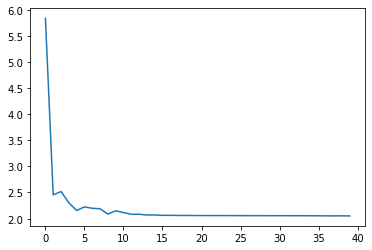

In [334]:
plt.plot(loss_arr)

In [387]:
for images, bbox_labels in train_ds.take(3):
    pred = model(images)

images.shape, bbox_labels.shape, pred.shape

(TensorShape([32, 227, 227, 3]), TensorShape([32, 7]), TensorShape([32, 7]))

In [388]:
def get_bboxed_images(images, bboxes, colors):
    bbox_tf = tf.stack([bboxes[..., 1], bboxes[..., 0],
                        bboxes[..., 3], bboxes[..., 2]],
                      axis=1)
    
    # expand the bbox dimension : to specify one bbox per image
    bbox_tf = tf.expand_dims(bbox_tf, axis=1)  # [BS, 1, 4]
    images = tf.image.draw_bounding_boxes(images, bbox_tf, colors=colors)
    
    return images

# draw predicted and gt boxes on the images
gt_colors = tf.constant([[0, 0, 1, 1]], tf.float32) #RGBA - blue
pred_colors = tf.constant([[1, 0, 0, 1]], tf.float32) #RGBA - pred

# Ground Truth labels
images_ = get_bboxed_images(images, bbox_labels[:,:4], gt_colors)
# predicted bounding boxes
images_ = get_bboxed_images(images_, pred[:,:4], pred_colors)

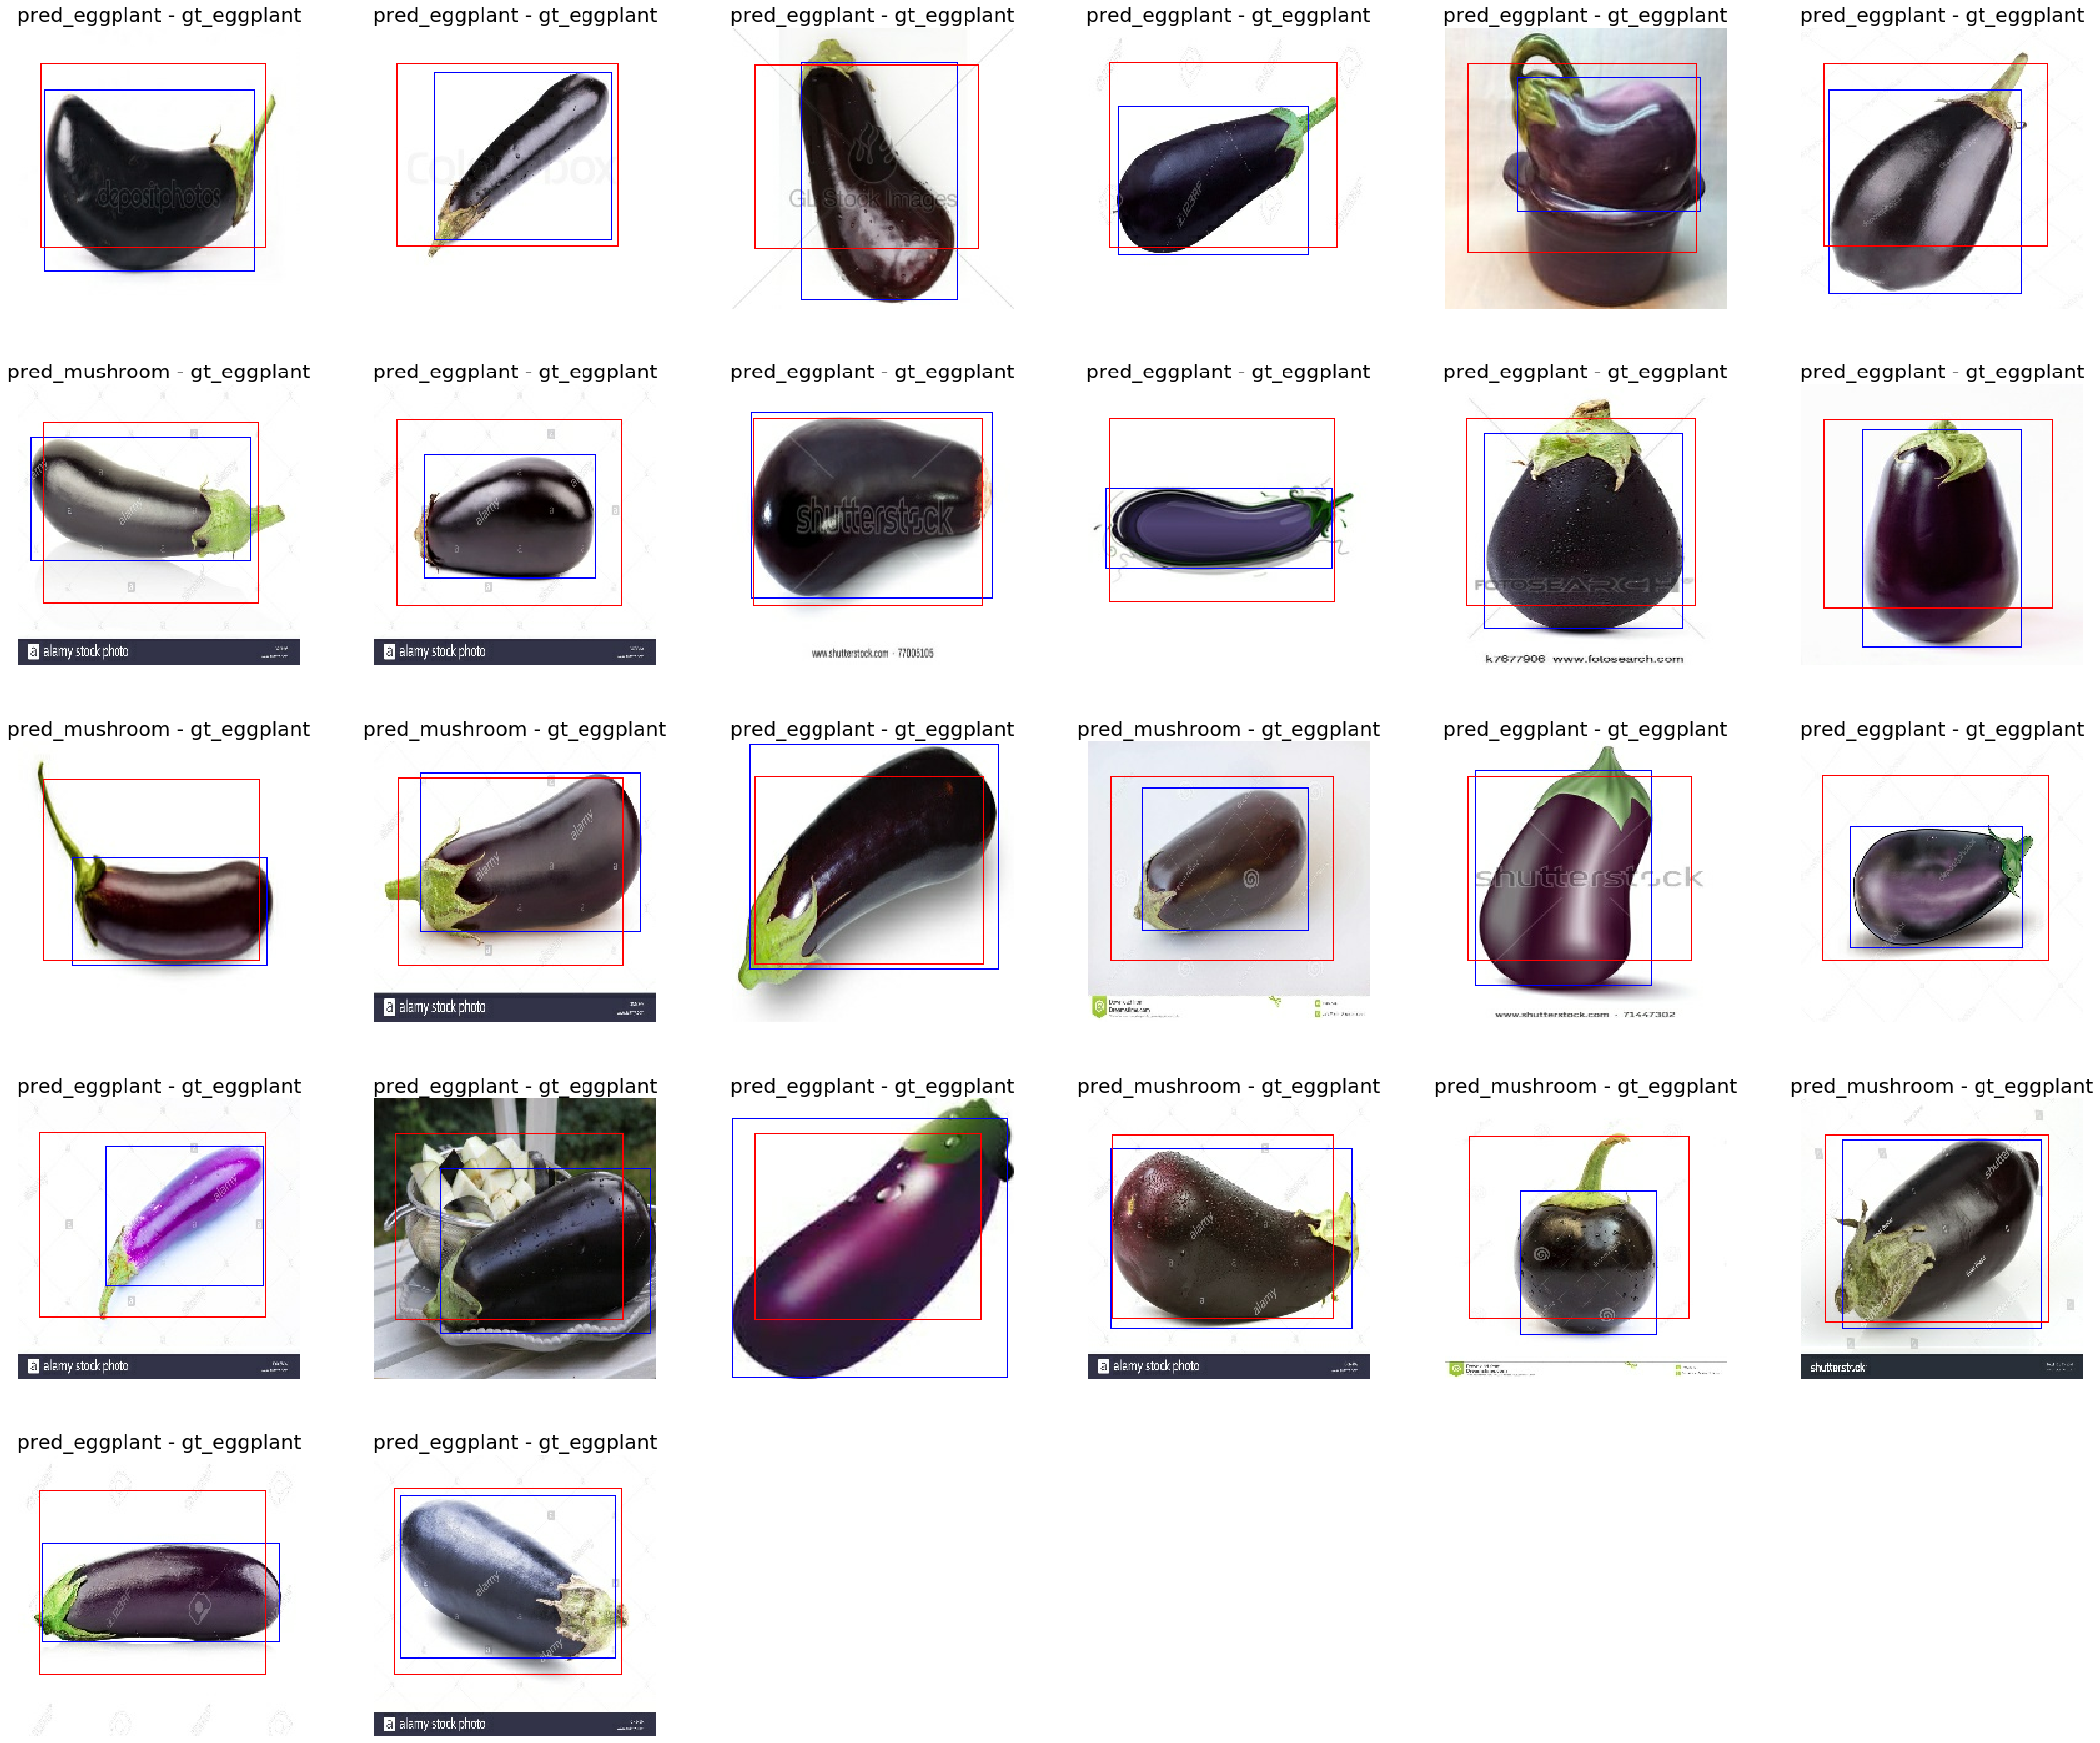

In [391]:
plt.figure(figsize=(30,30))
for i in range(26):
    ax = plt.subplot(6,6, i+1)
    plt.imshow(images_[i])
    plt.axis('off')
    plt.title('pred_' + CLASS_NAMES[tf.argmax(pred[i, 4:])] +
              ' - gt_'+ CLASS_NAMES[tf.argmax(bbox_labels[i, 4:])], fontdict={'fontsize':20})
plt.tight_layout()
plt.show()